<a href="https://colab.research.google.com/github/Kryptera-K/TECH-Hybrid-Ichimoku-Bollinger-Regime-Strategy/blob/main/TECH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.8/527.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "TECH"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("TECH_clean.csv", index=False)
df

/tmp/ipython-input-2447034331.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,6.079834,6.177896,5.713736,5.909860,2340000
2000-01-04,5.733348,5.936009,5.596061,5.936009,1873600
2000-01-05,5.648361,5.785648,5.622211,5.713736,2765600
2000-01-06,5.445700,5.720273,5.347638,5.671242,757600
2000-01-07,5.435893,5.609135,5.399937,5.429355,1299200
...,...,...,...,...,...
2025-12-12,58.509998,60.599998,58.240002,60.570000,2371200
2025-12-15,58.689999,60.279999,57.430000,59.779999,1723700
2025-12-16,57.439999,58.900002,56.590000,58.740002,2750500


In [ ]:
BB_PERIOD = 20
BB_SHIFT = 5
BB_STD = 2
ICHIMOKU_DISPLACEMENT = 26
ICHIMOKU_KIJUN_PERIOD = 26
ICHIMOKU_SENKOU_B_PERIOD = 52
ICHIMOKU_TENKAN_PERIOD = 9

# -------------------------
# Indicator Functions
# -------------------------

def price_cross_kijun_bearish(df):
    df = calculate_ichimoku(df)
    return (df['Close'].shift(1) > df['kijun_sen'].shift(1)) & (df['Close'] < df['kijun_sen'])


def calculate_ichimoku(df, tenkan_period=ICHIMOKU_TENKAN_PERIOD, kijun_period=ICHIMOKU_KIJUN_PERIOD, senkou_b_period=ICHIMOKU_SENKOU_B_PERIOD, displacement=ICHIMOKU_DISPLACEMENT):
    df = df.copy()

    # Lines
    df['tenkan_sen'] = (df['High'].rolling(tenkan_period).max() + df['Low'].rolling(tenkan_period).min()) / 2
    df['kijun_sen'] = (df['High'].rolling(kijun_period).max() + df['Low'].rolling(kijun_period).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(displacement)
    df['senkou_span_b'] = ((df['High'].rolling(senkou_b_period).max() + df['Low'].rolling(senkou_b_period).min()) / 2).shift(displacement)
    df['chikou_span'] = df['Close'].shift(-displacement)

    return df


def bb_open_above_upper_after_below(df, period=BB_PERIOD, std_multiplier=BB_STD, shift=BB_SHIFT):
    df = calculate_bollinger_bands(df, period, std_multiplier)
    return (df['Open'] > df['BB_Upper']) & (df['Open'].shift(shift) < df['BB_Upper'].shift(shift))


def calculate_bollinger_bands(df, period=BB_PERIOD, std_multiplier=BB_STD):
    """
    Calculate Bollinger Bands: Middle, Upper, and Lower.
    """
    df = df.copy()
    df['BB_MA'] = df['Close'].rolling(window=period).mean()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * df['Close'].rolling(window=period).std()
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * df['Close'].rolling(window=period).std()
    return df



# -------------------------
# Entry conditions
# -------------------------

df["Ichimoku_Price_Cross_Kijun_Bearish"] = price_cross_kijun_bearish(df)

# -------------------------
# Exit conditions
# -------------------------

df["BB_Open_Above_Upper_after_Below"] = bb_open_above_upper_after_below(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'Ichimoku_Price_Cross_Kijun_Bearish',
]
exit_conditions = [
    'BB_Open_Above_Upper_after_Below',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2000-01-03 00:00:00
End                                  2025-12-18 00:00:00
Period                                6531 days 00:00:00
Start Value                                     100000.0
End Value                                 1591817.485656
Total Return [%]                             1491.817486
Benchmark Return [%]                          872.781164
Max Gross Exposure [%]                             100.0
Total Fees Paid                            159970.604165
Max Drawdown [%]                               60.512084
Max Drawdown Duration                 1037 days 00:00:00
Total Trades                                         105
Total Closed Trades                                  104
Total Open Trades                                      1
Open Trade PnL                             -41714.966112
Win Rate [%]                                   72.115385
Best Trade [%]                                 40.398593
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-12-18 00:00:00
Period                         6531 days 00:00:00
Start Value                              100000.0
End Value                           972781.164233
Total Return [%]                       872.781164
Benchmark Return [%]                   872.781164
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        74.080277
Max Drawdown Duration          1966 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      872781.164233
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-1206553319.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


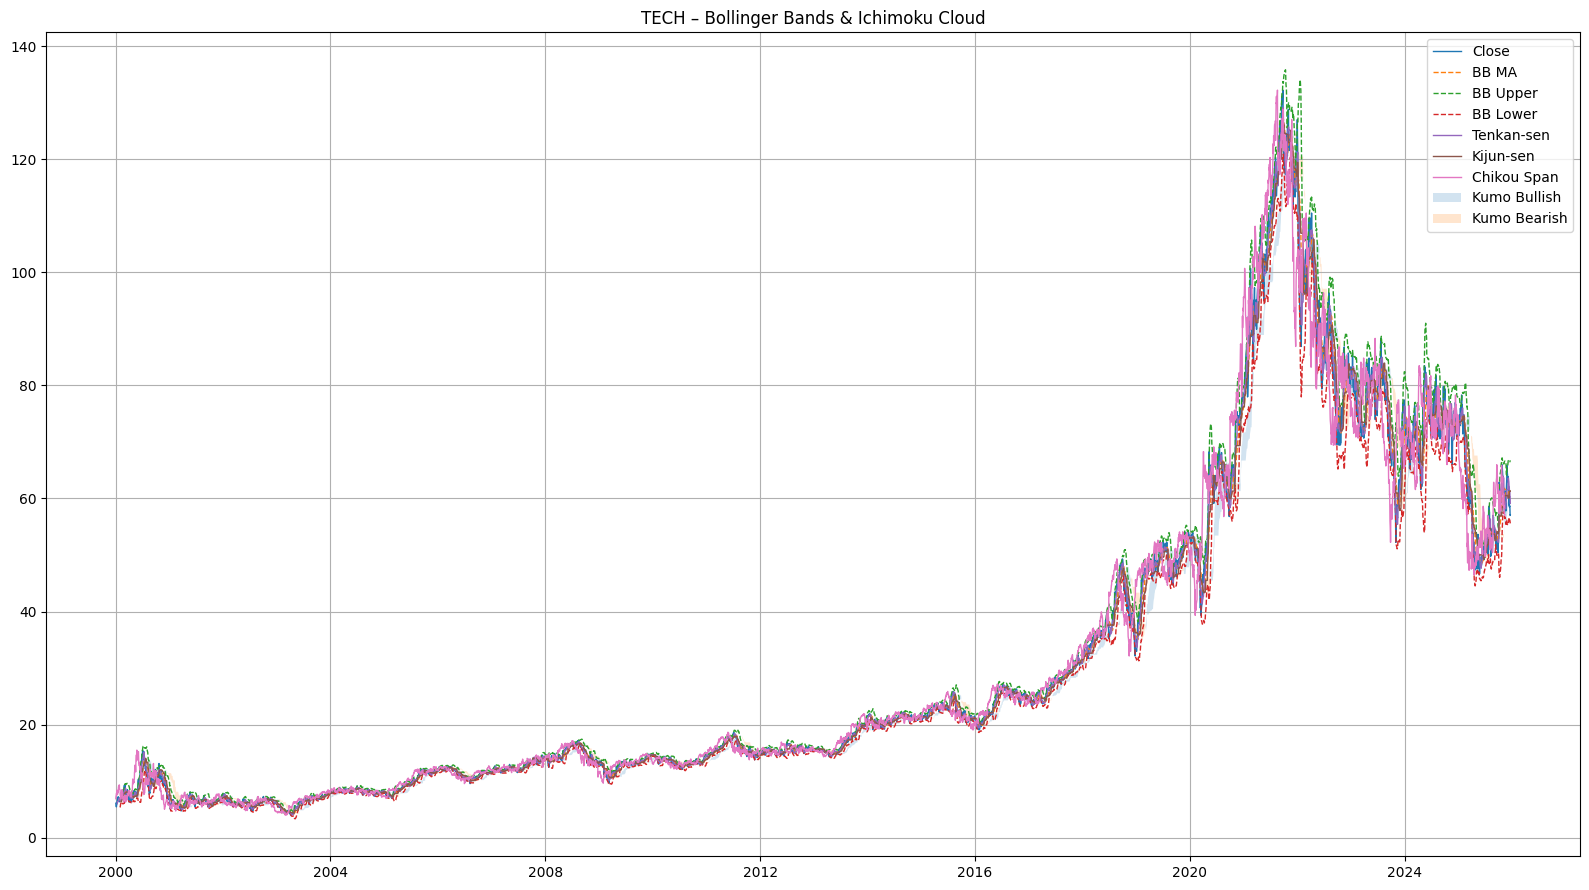

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------
symbol = "TECH"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Parameters
# -------------------------
BB_PERIOD = 20
BB_STD = 2
ICHIMOKU_DISPLACEMENT = 26
ICHIMOKU_KIJUN_PERIOD = 26
ICHIMOKU_SENKOU_B_PERIOD = 52
ICHIMOKU_TENKAN_PERIOD = 9

# -------------------------
# Indicator Calculations
# -------------------------
def calculate_bollinger_bands(df, period, std_multiplier):
    df = df.copy()
    df['BB_MA'] = df['Close'].rolling(period).mean()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * df['Close'].rolling(period).std()
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * df['Close'].rolling(period).std()
    return df

def calculate_ichimoku(df):
    df = df.copy()

    df['tenkan_sen'] = (
        df['High'].rolling(ICHIMOKU_TENKAN_PERIOD).max() +
        df['Low'].rolling(ICHIMOKU_TENKAN_PERIOD).min()
    ) / 2

    df['kijun_sen'] = (
        df['High'].rolling(ICHIMOKU_KIJUN_PERIOD).max() +
        df['Low'].rolling(ICHIMOKU_KIJUN_PERIOD).min()
    ) / 2

    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(ICHIMOKU_DISPLACEMENT)

    df['senkou_span_b'] = (
        (df['High'].rolling(ICHIMOKU_SENKOU_B_PERIOD).max() +
         df['Low'].rolling(ICHIMOKU_SENKOU_B_PERIOD).min()) / 2
    ).shift(ICHIMOKU_DISPLACEMENT)

    df['chikou_span'] = df['Close'].shift(-ICHIMOKU_DISPLACEMENT)

    return df

# Apply indicators
df = calculate_bollinger_bands(df, BB_PERIOD, BB_STD)
df = calculate_ichimoku(df)

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(16, 9))

# Price
plt.plot(df.index, df['Close'], label='Close', linewidth=1)

# Bollinger Bands
plt.plot(df.index, df['BB_MA'], linestyle='--', linewidth=1, label='BB MA')
plt.plot(df.index, df['BB_Upper'], linestyle='--', linewidth=1, label='BB Upper')
plt.plot(df.index, df['BB_Lower'], linestyle='--', linewidth=1, label='BB Lower')

# Ichimoku Lines
plt.plot(df.index, df['tenkan_sen'], linewidth=1, label='Tenkan-sen')
plt.plot(df.index, df['kijun_sen'], linewidth=1, label='Kijun-sen')
plt.plot(df.index, df['chikou_span'], linewidth=1, label='Chikou Span')

# Ichimoku Cloud
plt.fill_between(
    df.index,
    df['senkou_span_a'],
    df['senkou_span_b'],
    where=df['senkou_span_a'] >= df['senkou_span_b'],
    alpha=0.2,
    interpolate=True,
    label='Kumo Bullish'
)

plt.fill_between(
    df.index,
    df['senkou_span_a'],
    df['senkou_span_b'],
    where=df['senkou_span_a'] < df['senkou_span_b'],
    alpha=0.2,
    interpolate=True,
    label='Kumo Bearish'
)

plt.title(f"{symbol} – Bollinger Bands & Ichimoku Cloud")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
